In [2]:
import nibabel as nib
import os
import scipy.io as sio
from nilearn import plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as ss

# import pylab

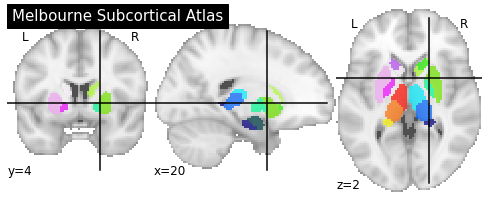

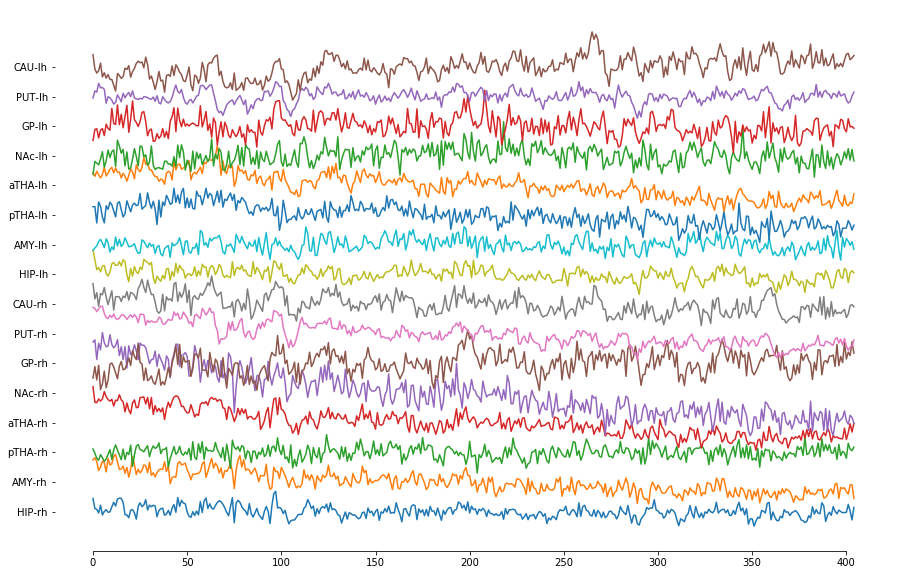

In [6]:
# VISUALIZE fMRI

sub_id = '100206'
scan_id = 'WM_LR'

path = '/bigdata/HCP_task/WM2/'+ sub_id +'/MNINonLinear/Results/tfMRI_' + scan_id
fname = path + '/tfMRI_' + scan_id + '.nii.gz'

# load raw (not blurred) scan 
subj_scan = nib.load(fname)
fmri = subj_scan.get_fdata()

# load subcortical atlas
# this atlas is single 3d volume with varying labels (non-overlapping)

atlas_path = '/data/gm-atlases/Tian2020MSA/7T_2mm/Tian_Subcortex_S1_7T_2mm.nii.gz'

atlas_name = 'tian'

atlas = nib.load(atlas_path)
affine = atlas.affine
volume = atlas.get_fdata()

# plot atlas
new_img = nib.Nifti1Image(volume, affine)
plotting.plot_roi(new_img, title='Melbourne Subcortical Atlas')
plt.show()

subcor_ts = []
for i in np.unique(volume):
    if i != 0: 
        bool_roi = np.zeros(volume.shape, dtype=int)
        bool_roi[volume == i] = 1
        bool_roi = bool_roi.astype(np.bool)
        
        # extract time-series data for each roi
        roi_ts_mean = []
        for t in range(fmri.shape[-1]):
            roi_ts_mean.append(np.mean(fmri[:, :, :, t][bool_roi]))
        
        subcor_ts.append(np.array(roi_ts_mean))
        
Y = np.array(subcor_ts).T

# load labels
label_file = '/data/gm-atlases/Tian2020MSA/3T/Subcortex-Only/Tian_Subcortex_S1_3T_label.txt'
with open(label_file) as f:
    labels = [line.strip('\n') for line in f.readlines()]

# demean and offset for visualization purposes only
Yd = Y-np.mean(Y, axis=0)

# add offset (space the y-axis appropriately for visual inspection - no longer the accurate values)
offset = 300 #points
Y_do = np.zeros(Y.shape)
for i in range(len(labels)):
    Y_do[: , i] = Yd[:, i] + i*offset

# plot extracted time-series signals
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(Y_do)

# show labels
ax.set_yticks(np.mean(Y_do, axis=0))
ax.set_yticklabels(labels)

sns.despine(left=True, trim=True)
plt.show()

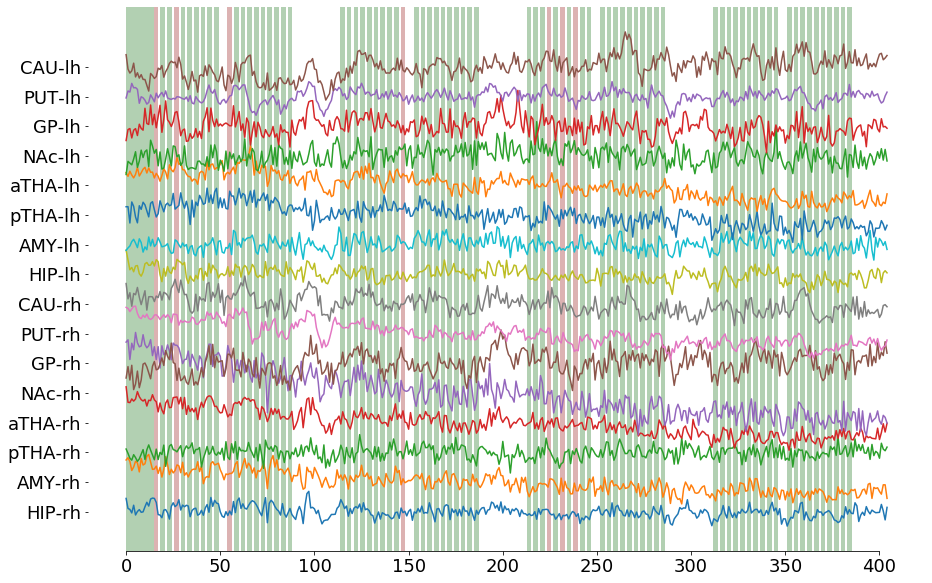

In [72]:
# Visualize fMRI physio
# load task blocks (EVs)
path = '/bigdata/HCP_task/WM2/'+ sub_id +'/MNINonLinear/Results/tfMRI_' + scan_id + '/EVs/'
hit =  np.loadtxt(path + 'all_bk_cor.txt')
hit = [i[0]*1/0.72 for i in hit] 
miss = np.loadtxt(path + 'all_bk_err.txt')
miss = [j[0]*1/0.72 for j in miss]

# plot extracted time-series signals
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(Y_do)
sns.despine(left=True, trim=True)

# show labels
ax.set_yticks(np.mean(Y_do, axis=0))
ax.set_yticklabels(labels)

# plot task blocks
ax.axvspan(0, np.min([miss[0],hit[0]]), facecolor="darkgreen", alpha=.3)
duration = 2.5
for each in hit:
    ax.axvspan(each, each + duration, facecolor="darkgreen", alpha=.3)
    
for each in miss:
    ax.axvspan(each, each + duration, facecolor="darkred", alpha=.3)

plt.show()

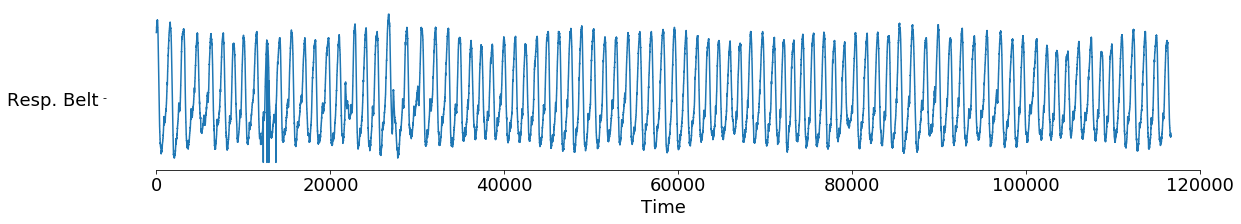

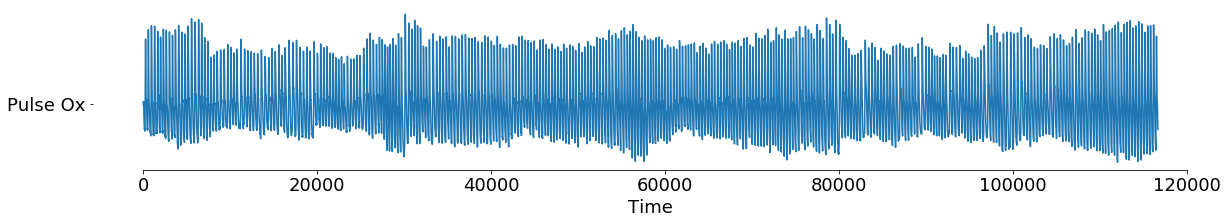

In [8]:
# Visualize fMRI physio
path = '/bigdata/HCP_task/WM2/'+ sub_id +'/MNINonLinear/Results/tfMRI_' + scan_id
phys_fname =  path + '/tfMRI_' + scan_id + '_Physio_log.txt'

# load wm and csf
df = pd.read_csv(phys_fname, header=None, sep='\t', names=['', 'Resp Belt', 'Pulse Ox'])
resp = df.iloc[:, 1].values
card = df.iloc[:, 2].values

fig, ax = plt.subplots(figsize=(20,3))
plt.rcParams.update({'font.size': 18})

plt.xlabel('Time')
plt.plot(resp - np.mean(resp))
# show labels
ax.set_yticks([0])
ax.set_yticklabels(['Resp. Belt'])
sns.despine(left=True, trim=True)
plt.show()

fig, ax = plt.subplots(figsize=(20,3))
plt.rcParams.update({'font.size': 18})

plt.xlabel('Time')
plt.plot(card-np.mean(card))
# show labels
ax.set_yticks([0])
ax.set_yticklabels(['Pulse Ox'])
sns.despine(left=True, trim=True)
plt.show()

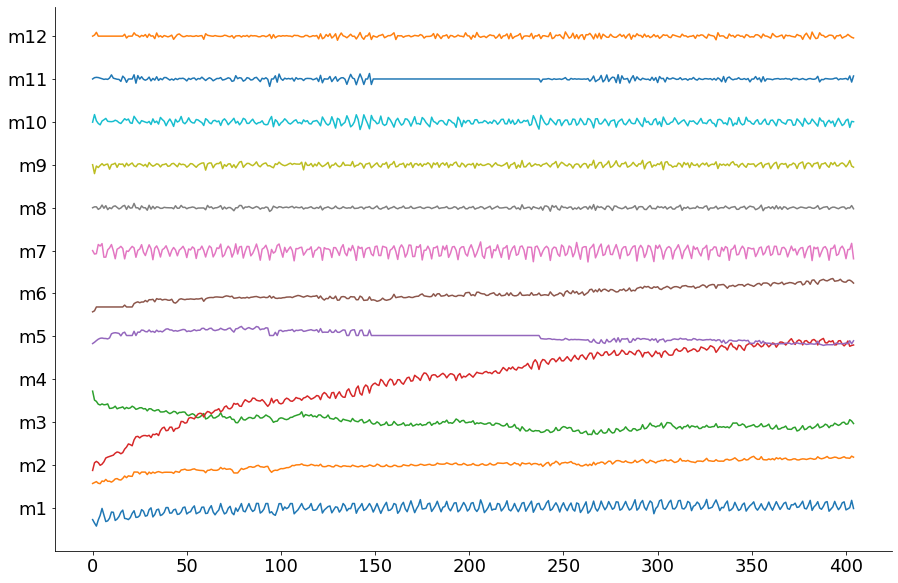

In [9]:
path = '/bigdata/HCP_task/WM2/'+ sub_id +'/MNINonLinear/Results/tfMRI_' + scan_id
mov_fname =  path + '/Movement_Regressors.txt'

# movement regressors
num_reg = 12
m = []
for i in range(num_reg):
    m.append('m{}'.format(i+1))

mov = np.loadtxt(mov_fname)
mov = mov - np.mean(mov, axis=0)

offset = 0.4 #points
movs = np.zeros(mov.shape)
for i in range(len(m)):
    movs[: , i] = mov[:, i] + i*offset

fig, ax = plt.subplots(figsize=(15,10))
plt.plot(movs)
ax.set_yticks(np.mean(movs, axis=0))
ax.set_yticklabels(m)

sns.despine()
plt.show()